In [1]:
import sys

import numpy as np
import pandas as pd

sys.path.insert(
    1, '/Users/haas/Documents/Masters/MachineLearning/FYS-STK4155/project3'
)

import random

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from activation_functions import *
from FFNN import FFNN

# import accuracy score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
)
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from utils import *

cmt = 1 / 2.54
sns.set_palette('pastel')

## Training Regression

8/8 [==============================] - 0s 6ms/step
RMSE1:  0.09369366422635796
rmse over average of ytest with LeNet-5 =  0.04245911094461403
CPU times: user 35min 7s, sys: 3min 13s, total: 38min 21s
Wall time: 7min 4s


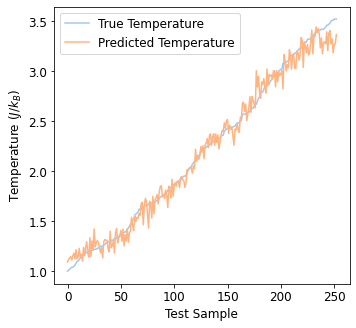

In [22]:
%%time

# lenet inspired model
# now we replicate LeNet-5
Xtrain, Xtest, ytrain, ytest = Ising.load_data()
# first reshape Xtrain and Xtest to 4D arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)
# create model
model1 = Sequential()
# add model layers
eta = 1e-4
l2 = 0.01
l2_reg = regularizers.l2(l2)
epochs = 1000
model1.add(
    Conv2D(
        6,
        kernel_size=5,
        activation='leaky_relu',
        input_shape=(50, 50, 1),
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
# model.add(AveragePooling2D(pool_size=(4, 4)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(
    Conv2D(
        16,
        kernel_size=5,
        activation='leaky_relu',
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
model1.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(AveragePooling2D(pool_size=(4, 4)))
model1.add(Flatten())
model1.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
model1.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
model1.add(Dense(1, activation='linear'))
# compile model using accuracy to measure model performance
sgd = SGD(learning_rate=eta, decay=5e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=eta, beta_1=0.9, beta_2=0.999, amsgrad=False)

model1.compile(optimizer=adam, loss='mse', metrics='mse')
# train the model
history1 = model1.fit(
    Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=epochs, verbose=0
)   #### change this
#
# evaluate the model
pred1 = model1.predict(Xtest)
order = np.argsort(ytest.ravel())
ytest = ytest[order]
pred1 = pred1[order]

# plot predictions
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(ytest, label='True Temperature')
plt.plot(pred1, label='Predicted Temperature')
plt.legend() 
plt.xlabel('Test Sample')
plt.ylabel('Temperature $(J/k_B)$')
# change ticks font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


info = (
    f'_l2reg{str(l2).replace(".", "")}'
    + '_eta'
    + str(eta).replace('.', '')
    + f'_epoch{str(epochs)}'
)
plt.tight_layout()
plt.savefig('../figs/TF_CNN' + info + '.pdf')


print('RMSE1: ', mean_squared_error(ytest, pred1, squared=False))
rmse1 = np.sqrt(mean_squared_error(pred1, ytest.ravel())) / np.mean(ytest)
print('rmse over average of ytest with LeNet-5 = ', rmse1)


### Parsing Ahmed text file to try to predict temp

In [23]:
data = pd.read_csv("../data/50/Simulation Results_Dim50_Temp1.50_Field0.0_SweepNum10000.txt", header=None, sep="\t")
X = data.to_numpy()
X = X.reshape(1, 50, 50, 1)

In [40]:
print("Predicted temperature: ", model1.predict(X)[0][0], " (J/k_B)")

1/1 [==============================] - 0s 198ms/step
Predicted temperature:  1.5106943  (J/k_B)


# Now I will try to speed up the training process and measure it in a more systematic way

In [2]:
Xtrain, Xtest, ytrain, ytest = Ising.load_data()
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)

In [3]:

def train_time_exploration(eta, l2, epochs, Xtrain, Xtest, ytrain, ytest, scheduler = False):
    model1 = Sequential()
    # add model layers

    l2_reg = regularizers.l2(l2)
    model1.add(
        Conv2D(
            6,
            kernel_size=5,
            activation='leaky_relu',
            input_shape=(50, 50, 1),
            kernel_regularizer=l2_reg,
            padding='same',
        )
    )

    model1.add(MaxPooling2D(pool_size=(2, 2)))
    model1.add(
        Conv2D(
            16,
            kernel_size=5,
            activation='leaky_relu',
            kernel_regularizer=l2_reg,
            padding='same',
        )
    )
    model1.add(MaxPooling2D(pool_size=(2, 2)))

    model1.add(Flatten())
    model1.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
    model1.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
    model1.add(Dense(1, activation='linear'))

    # sgd = SGD(learning_rate=eta, decay=5e-6, momentum=0.9, nesterov=True)
    if scheduler != False:
        eta = ExponentialDecay(
            initial_learning_rate=5*eta,
            decay_steps=10000,
            decay_rate=0.9)

    adam = Adam(learning_rate=eta, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model1.compile(optimizer=adam, loss='mse', metrics='mse')

    # train the model
    history1 = model1.fit(
        Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=epochs, verbose=0
    )   #### change this

    # evaluate the model
    pred1 = model1.predict(Xtest)
    order = np.argsort(ytest.ravel())
    ytest = ytest[order]
    pred1 = pred1[order]

    # plot predictions
    #plt.rcParams.update({'font.size': 12})
    #fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
    #plt.plot(ytest, label='True Temperature')
    #plt.plot(pred1, label='Predicted Temperature')
    #plt.legend()
    #plt.xlabel('Test Sample')
    #plt.ylabel('Temperature $(J/k_B)$')
    ## change ticks font size
    #plt.xticks(fontsize=12)
    #plt.yticks(fontsize=12)
#
#
    #info = (
    #    f'_l2reg{str(l2).replace(".", "")}'
    #    + '_eta'
    #    + str(eta).replace('.', '')
    #    + f'_epoch{str(epochs)}'
    #)
    #plt.tight_layout()
    #plt.savefig('../figs/TF_CNN' + info + '.pdf')


    #print('RMSE1: ', mean_squared_error(ytest, pred1, squared=False))
    rmse1 = np.sqrt(mean_squared_error(pred1, ytest.ravel())) / np.mean(ytest)
    #print('rmse over average of ytest', rmse1)
    return rmse1, history1


In [5]:
import time

In [8]:
eta = 1e-4
l2 = 0.01
#epochs = 20
rmse_no_scheduler = []
rmse_scheduler = []
times_no_scheduler = []
times_scheduler = []
epochs = 20

    # time the training
start_no_scheduler = time.time()
rmse, history_no_scheduler =  train_time_exploration(eta, l2, epochs, Xtrain, Xtest, ytrain, ytest, scheduler = False)
end_no_scheduler = time.time()
start_scheduler = time.time()
rmse, history_scheduler = train_time_exploration(eta, l2, epochs, Xtrain, Xtest, ytrain, ytest, scheduler = True)
end_scheduler = time.time()
times_no_scheduler.append(end_no_scheduler - start_no_scheduler)
times_scheduler.append(end_scheduler - start_scheduler)




plt.plot(epcohs_list, rmse_no_scheduler, label = "No scheduler")
plt.plot(epcohs_list, rmse_scheduler, label = "Scheduler")
# plot also the avg rmse over the epochs for the two cases
avg_rmse_no_scheduler = np.mean(rmse_no_scheduler)
avg_rmse_scheduler = np.mean(rmse_scheduler)
plt.plot(epcohs_list, [avg_rmse_no_scheduler]*len(epcohs_list), label = "Avg RMSE no scheduler")
plt.plot(epcohs_list, [avg_rmse_scheduler]*len(epcohs_list), label = "Avg RMSE scheduler")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")

plt.savefig("../figs/TF_CNN_scheduler.pdf")


8/8 [==============================] - 0s 5ms/step


KeyboardInterrupt: 

Text(0, 0.5, 'RMSE')

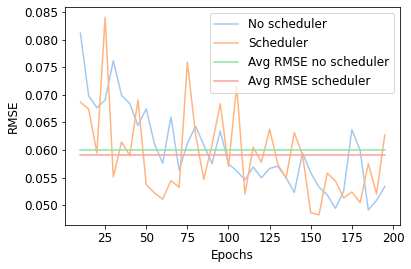

In [76]:
epochs = range(10, 200, 5)
plt.plot(epochs, rmse_no_scheduler, label = "No scheduler")
plt.plot(epochs, rmse_scheduler, label = "Scheduler")
# plot also the avg rmse over the epochs for the two cases
avg_rmse_no_scheduler = np.mean(rmse_no_scheduler)
avg_rmse_scheduler = np.mean(rmse_scheduler)
plt.plot(epochs, [avg_rmse_no_scheduler]*len(epochs), label = "Avg RMSE no scheduler")
plt.plot(epochs, [avg_rmse_scheduler]*len(epochs), label = "Avg RMSE scheduler")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")
